# DBSCAN

We run DBSCAN clustering on the full cardinality of the data obtained from _greg-features.ipynb_. But we only use the columns retained after running _centroid-sampling.ipynb_ and _dim-red-via-correlation.ipynb_.

Reference material:

* [sklearn DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)
* [DBSCAN demo](https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html)
* [Let’s cluster data points using DBSCAN](https://medium.com/@agarwalvibhor84/lets-cluster-data-points-using-dbscan-278c5459bee5)

<hr>

In [1]:
%pylab inline
%autosave 25

import umap
import pandas as pd
import seaborn as sns

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
import joblib

Populating the interactive namespace from numpy and matplotlib


Autosaving every 25 seconds


### Data location

In [2]:
data_loc = '../data/FDA-COVID19_files_v1.0/'

### Get the full data set

In [3]:
store = pd.HDFStore(data_loc + 'features.h5')
df_all = pd.DataFrame(store['df' ])
print('rows: {:,}, columns: {:,}'.format(len(df_all), len(df_all.columns)))
store.close()

rows: 184,063, columns: 17,076


### Take a subset of the columns

Exclude zero-variance and highly correlated columns, as found from analysing the centroid-based sampled data set.

In [4]:
store = pd.HDFStore(data_loc + 'sampled_data.h5')
meta = store.select('df', start=1, stop=1) # Grab on the column names. Speeds things up.
cols = meta.columns
store.close()
print('columns: {:,}'.format(len(cols)))

columns: 14,730


### Original data with reduced dimensionality

In [5]:
df_features = df_all[cols]
del df_all
del cols
print('rows: {:,}, columns: {:,}'.format(len(df_features), len(df_features.columns)))

rows: 184,063, columns: 14,730


### Scale to range (0, 1)

Note: previsouly used StandardScaler on all columns except fingerprint and binding-sites but this took a lot of time and resources to calculate with no apparrent additional benefit. So switched to simpler MinMaxScaler over all columns.

In [6]:
scaler = MinMaxScaler()
drop_cols = ['cid', 'pid', 'activity']
features = df_features.drop(columns=drop_cols, axis=1)
features = scaler.fit_transform(features.values)

In [7]:
df_drop = df_features[drop_cols]
cols = df_features.columns.tolist()[3:]
del df_features

df_features = pd.DataFrame(columns=cols, data=features)
df_features[drop_cols] = pd.DataFrame(df_drop.values)

del df_drop
df_features.head()

,AEK,VEL,EKF,LGM,VKN,LKP,NEE,TPN,SRL,KEY,...,4089,4090,4091,4092,4093,4094,4095,cid,pid,activity
0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38258,CAA96025,0
1,0.616716,0.0,0.0,0.0,0.59088,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38258,XP_717710,0
2,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38258,O86157,0
3,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38258,P08659,0
4,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38258,ADQ57959,0


### Takes a while to scale so save for later

In [8]:
# save the scaled features to file to save running this slow op again
store = pd.HDFStore(data_loc + 'dbscan_scaled_data.h5')
store['df'] = df_features
store.close()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3325: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->['cid', 'pid', 'activity']]

  exec(code_obj, self.user_global_ns, self.user_ns)


### Load pre-scaled data

In [3]:
store = pd.HDFStore(data_loc + 'dbscan_scaled_data.h5')
df_features = pd.DataFrame(store['df' ])
print('rows: {:,}, columns: {:,}'.format(len(df_features), len(df_features.columns)))
store.close()

rows: 184,063, columns: 14,730


## Cluster — DBSCAN

#### 1. Interpoint distances to estimate Eps

Plot interpoint distances over the centroid-sample set to see if we can determine a decent value for DBSCAN's epsilon parameter.

Do this by taking knn with _k = 3_ over a sample of the data and then plotting those distances. We look for a noticiable knee in the plot as a contender for DBSCAN epsilon.

Reference material:

* [scikit-learn: Nearest Neighbors](https://scikit-learn.org/stable/modules/neighbors.html)
* [Knn distance plot for determining eps of DBSCAN](https://datascience.stackexchange.com/questions/10162/knn-distance-plot-for-determining-eps-of-dbscan)

In [72]:
store = pd.HDFStore(data_loc + 'xgboost_features_data.h5')
df_sampled = pd.DataFrame(store['df' ])
print('rows: {:,}, columns: {:,}'.format(len(df_sampled), len(df_sampled.columns)))
store.close()

rows: 22,172, columns: 737


In [37]:
from sklearn.neighbors import NearestNeighbors

df_sampled_sampled = df_sampled.sample(1000, random_state=42)
X = df_sampled_sampled.drop(['cid', 'pid', 'activity'], axis=1).values

X = MinMaxScaler().fit_transform(X)

nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(X)

rows: 22,172, columns: 737


In [38]:
distances, indices = nbrs.kneighbors(X)
third_n = distances[:, 2]
third_n.sort(axis=0)

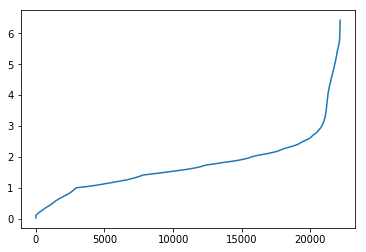

In [39]:
_ = plt.plot(third_n)

#### 2. Run DBSCAN

In [73]:
X = df_sampled.drop(['cid', 'pid', 'activity'], axis=1).values
X = MinMaxScaler().fit_transform(X)
X.shape

(22172, 734)

In [22]:
db = DBSCAN(eps=5, min_samples=10).fit(X)

#### save the model

In [43]:
joblib.dump(db, data_loc + 'dbscam_sampled_model.mdl')

['../data/FDA-COVID19_files_v1.0/dbscam_sampled_model.mdl']

#### load the model

In [3]:
db = joblib.load(data_loc + 'dbscam_sampled_model.mdl')

In [4]:
db.labels_

array([ 0,  1,  2, ...,  0, -1,  0])

In [5]:
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

In [6]:
n_clusters_

174

In [7]:
n_noise_

2845

In [8]:
len(labels)

22172

In [10]:
hist = np.histogram(labels, bins=174)
hist

(array([ 2845, 13968,   524,   563,    39,    32,    73,    13,   479,
           20,    34,    55,    38,    60,    49,    13,    12,   124,
           16,    39,    39,    14,    23,    14,    17,    11,    12,
           14,    10,    46,    20,    14,    15,    85,    10,    10,
          105,    14,    26,    10,    10,    53,    16,    13,    17,
           29,    23,    14,    11,    22,    47,    14,    10,    24,
           22,    42,    15,    26,    24,    25,    78,    28,    11,
           26,    46,    53,    27,    17,    21,    11,    15,    20,
           16,    10,    10,    10,    30,    11,    34,    12,    19,
           15,    21,    17,    10,    46,    99,    49,    15,    26,
           18,    60,    10,    16,    11,    13,    19,    16,   101,
           12,    16,    10,    48,    20,    13,    16,    10,    11,
           10,    30,    23,    14,    41,    15,    11,    13,    12,
           14,    10,    12,    16,    10,    13,    10,    10,    29,
      

In [103]:
i = np.argsort(-hist[0])[:10]
idx = hist[1][i]
num = range(len(hist[0]))
c = [list(sns.color_palette()[x]) for x in range(10)]

largest_clusters = [list(a) for a in zip(idx, num, c)]

# swap out the gray with white:
largest_clusters[7][2] = [1.0, 1.0, 1.0]
largest_clusters

[[0.0, 0, [0.12156862745098039, 0.4666666666666667, 0.7058823529411765]],
 [-1.0, 1, [1.0, 0.4980392156862745, 0.054901960784313725]],
 [2.0, 2, [0.17254901960784313, 0.6274509803921569, 0.17254901960784313]],
 [1.0, 3, [0.8392156862745098, 0.15294117647058825, 0.1568627450980392]],
 [7.0, 4, [0.5803921568627451, 0.403921568627451, 0.7411764705882353]],
 [16.0, 5, [0.5490196078431373, 0.33725490196078434, 0.29411764705882354]],
 [35.0, 6, [0.8901960784313725, 0.4666666666666667, 0.7607843137254902]],
 [97.0, 7, [1.0, 1.0, 1.0]],
 [85.0, 8, [0.7372549019607844, 0.7411764705882353, 0.13333333333333333]],
 [32.0, 9, [0.09019607843137255, 0.7450980392156863, 0.8117647058823529]]]

#### show clusters in UMAP embedding

In [74]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.3)
embedding_sampled = reducer.fit_transform(X)

In [105]:
indices = np.array(largest_clusters).T[0].tolist()

In [110]:
gray = (0.4980392156862745, 0.4980392156862745, 0.4980392156862745)

colors = []
for x in labels:
    if x in indices:
        idx = indices.index(x)
        if x == -1:
            colors.append(gray) # grayed out
        else:
            colors.append(largest_clusters[idx][2])
    else:
        colors.append(largest_clusters[7][2]) # grayed out

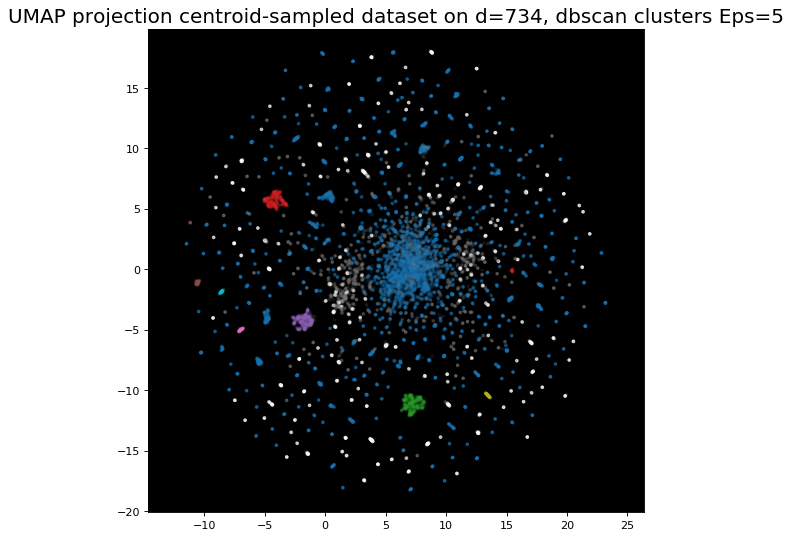

In [111]:
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(embedding_sampled[:, 0], embedding_sampled[:, 1], c=colors, s=5, alpha=0.1)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection centroid-sampled dataset on d=734, dbscan clusters Eps=5', fontsize=18);
ax = plt.gca()
ax.set_facecolor((0.0, 0.0, 0.0))

## Cluster — OPTICS

Reference material:

* [sklearn.cluster.OPTICS](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.OPTICS.html)
* [OPTICS algorithm](https://en.wikipedia.org/wiki/OPTICS_algorithm)
* [Demo of OPTICS clustering algorithm](https://scikit-learn.org/stable/auto_examples/cluster/plot_optics.html)

In [112]:
# Test on scaled, centroid-based sample.
store = pd.HDFStore(data_loc + 'xgboost_features_data.h5')
df_sampled = pd.DataFrame(store['df' ])
print('rows: {:,}, columns: {:,}'.format(len(df_sampled), len(df_sampled.columns)))
store.close()

scaler = MinMaxScaler()
drop_cols = ['cid', 'pid', 'activity']
X = df_sampled.drop(columns=drop_cols, axis=1)
X = scaler.fit_transform(X.values)

rows: 22,172, columns: 737


In [113]:
from sklearn.cluster import OPTICS, cluster_optics_dbscan

clust = OPTICS(min_samples=50, xi=.05, min_cluster_size=.05)

# Run the fit
clust.fit(X)

reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]

#### save for later

In [115]:
joblib.dump(clust, data_loc + 'optics_sampled_model.mdl')

['../data/FDA-COVID19_files_v1.0/optics_sampled_model.mdl']

In [114]:
len(labels)

22172